In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input, Dropout, Convolution2D, MaxPooling2D, Flatten, LeakyReLU, BatchNormalization
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.applications import VGG16

from sklearn.metrics import accuracy_score, confusion_matrix
from tensorflow.keras.optimizers import Adam

from PIL import Image 
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
LANDSCAPE_TYPE = 'buildings', 'forest', 'glacier', 'mountain', 'sea', 'street'

# configurar de acuerdo a dónde bajaron los sets de imágenes
TRAIN_DIR = Path('./ucse-ia-2024-tp-2-clasificacion-de-imagenes/train')
TEST_DIR = Path('./ucse-ia-2024-tp-2-clasificacion-de-imagenes/test')

SIZE = 100

In [3]:
images_reader = ImageDataGenerator(
    rescale=1/255,  # Normaliza los píxeles a valores entre 0 y 1
    rotation_range=20,  # Rotar imágenes aleatoriamente entre 0 y 20 grados
    width_shift_range=0.2,  # Desplazar horizontalmente hasta el 20% del ancho
    height_shift_range=0.2,  # Desplazar verticalmente hasta el 20% de la altura
    shear_range=0.2,  # Cortar (shear) imágenes aleatoriamente
    zoom_range=0.2,  # Ampliar imágenes aleatoriamente
    horizontal_flip=True,  # Voltear imágenes horizontalmente
    fill_mode='nearest',  # Estrategia para rellenar nuevos píxeles
    brightness_range=(0.5, 1.5),  # Cambiar brillo aleatoriamente
    validation_split=0.4  # Porcentaje para la validación (40%)
)

READ_PARAMS = dict(
    class_mode="categorical",
    classes=LANDSCAPE_TYPE, # para usar el mismo orden en todos lados
    target_size=(SIZE, SIZE), # para que corra más rápido, vamos a achicar las imágenes
    color_mode="rgb",  # queremos trabajar con las imágenes a color
    batch_size=32, # Tamaño del lote
)

In [4]:
# Generador para entrenamiento (60%)
train = images_reader.flow_from_directory(
    TRAIN_DIR,
    subset='training',
    **READ_PARAMS
)

# Generador para validación (40%)
validation = images_reader.flow_from_directory(
    TRAIN_DIR,
    subset='validation',
    **READ_PARAMS
)

Found 8424 images belonging to 6 classes.
Found 5610 images belonging to 6 classes.


In [5]:
def sample_images_train(dataset):
    plt.figure(figsize=(10, 10))
    images, labels = next(dataset)
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        plt.title(LANDSCAPE_TYPE[np.argmax(labels[i])])
        plt.axis("off")

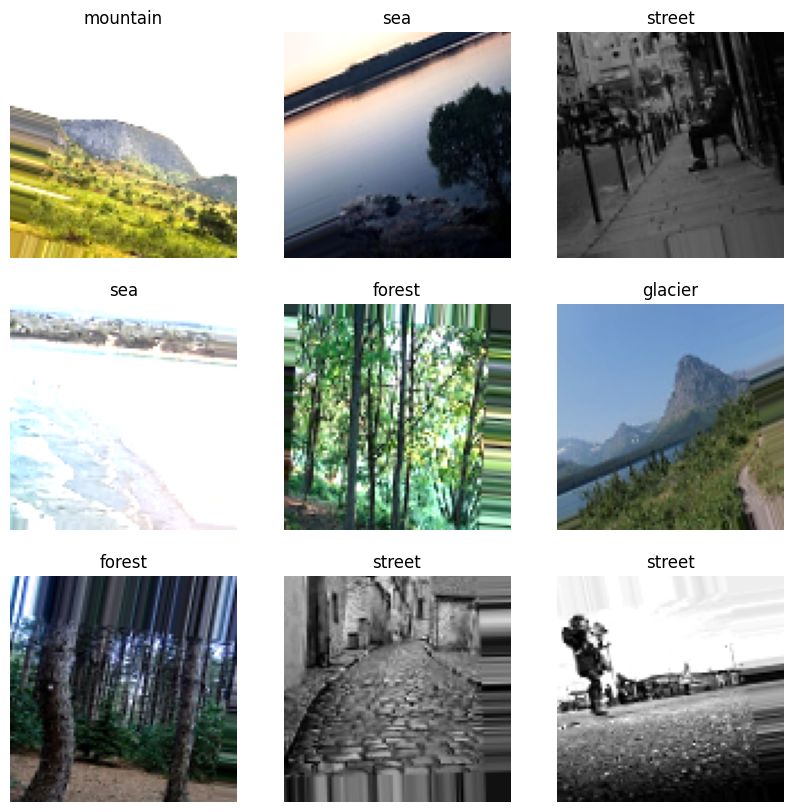

In [6]:
sample_images_train(train)

# 1 Análisis exploratorio sobre el conjunto de datos

## 1.1 Volumetría de los datos

In [7]:
def count_images_by_category(dataset_dir):
    categories = [d for d in os.listdir(dataset_dir) if os.path.isdir(os.path.join(dataset_dir, d))]
    category_counts = {}

    for category in categories:
        category_path = os.path.join(dataset_dir, category)
        image_files = [f for f in os.listdir(category_path) if f.endswith(('jpg', 'jpeg', 'png'))]
        category_counts[category] = len(image_files)

    total_images = sum(category_counts.values())

    return category_counts, total_images

# Obtener la volumetría de los datos
category_counts, total_images = count_images_by_category(TRAIN_DIR)

print("Volumetría del dataset:")
print(f"Total de imágenes: {total_images}")
for category, count in category_counts.items():
    print(f"{category}: {count} imágenes")

Volumetría del dataset:
Total de imágenes: 14034
forest: 2271 imágenes
buildings: 2191 imágenes
glacier: 2404 imágenes
street: 2382 imágenes
mountain: 2512 imágenes
sea: 2274 imágenes


## 1.2 Estructura y tipo de las imágenes

In [8]:
def get_image_dimensions(dataset_dir):
    image_dimensions = []
    image_formats = []
    for root, dirs, files in os.walk(dataset_dir):
        for file in files:
            if file.endswith(('jpg', 'jpeg', 'png')):
                img_path = os.path.join(root, file)
                img = Image.open(img_path)
                image_dimensions.append(img.size)  # Obtiene el tamaño (ancho, alto)
                image_formats.append(img.format)  # Obtiene el formato de la imagen
    
    return image_dimensions, image_formats

# Obtener la estructura de las imágenes
image_dimensions, image_formats = get_image_dimensions(TRAIN_DIR)

# Muestra algunos ejemplos de dimensiones y formatos
print("Ejemplos de dimensiones de imágenes:")
for i in range(5):
    print(f"Imagen {i+1}: {image_dimensions[i]} (Formato: {image_formats[i]})")


Ejemplos de dimensiones de imágenes:
Imagen 1: (150, 150) (Formato: JPEG)
Imagen 2: (150, 150) (Formato: JPEG)
Imagen 3: (150, 150) (Formato: JPEG)
Imagen 4: (150, 150) (Formato: JPEG)
Imagen 5: (150, 150) (Formato: JPEG)


## 1.3 Distribución de la variable a predecir

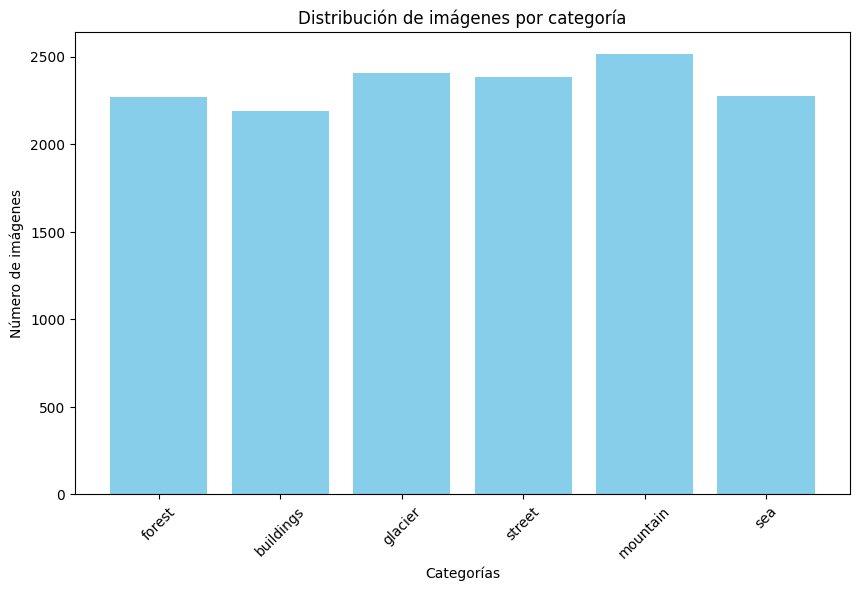

In [9]:
def plot_image_distribution(category_counts):
    categories = list(category_counts.keys())
    counts = list(category_counts.values())

    plt.figure(figsize=(10, 6))
    plt.bar(categories, counts, color='skyblue')
    plt.xlabel('Categorías')
    plt.ylabel('Número de imágenes')
    plt.title('Distribución de imágenes por categoría')
    plt.xticks(rotation=45)
    plt.show()

# Graficar la distribución de las imágenes por categoría
plot_image_distribution(category_counts)

# 2 Modelado

In [10]:
# UTILS

model_weights_at_epochs = {}

class OurCustomCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        model_weights_at_epochs[epoch] = self.model.get_weights()

# Función para plotear el historial de entrenamiento
def PlotHistory(history):
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='validation')
    plt.title('Accuracy over train epochs')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')
    plt.show()

class MLPBuilder:
    def __init__(
        self, 
        input_shape=(SIZE, SIZE, 3), 
        output_size=len(LANDSCAPE_TYPE),
    ):
        self.input_shape = input_shape  # Ej: (SIZE, SIZE, 3)
        self.output_size = output_size  # Ej: len(LANDSCAPE_TYPE)
        self.model = None
    
    def build_model(self, layers_config, batch_normalization=False):
        """
        Construye un modelo secuencial MLP basado en la configuración proporcionada.

        :param layers_config: Lista de diccionarios con la configuración de cada capa. 
                              Ej: [{'units': 1024, 'activation': 'tanh', 'dropout': 0.25}, {...}]
        """
        self.model = Sequential()
        
        # Primera capa: Flatten (Aplanar las imágenes)
        self.model.add(Flatten(input_shape=self.input_shape))
        
        # Agregar capas ocultas configuradas
        for layer in layers_config:            
            if layer['activation'] == 'leakyrelu':
                self.model.add(Dense(layer['units']))
                self.model.add(LeakyReLU(alpha=0.01))
            else:
                self.model.add(Dense(layer['units'], activation=layer['activation']))

            if batch_normalization:
                self.model.add(BatchNormalization())

            if 'dropout' in layer:
                self.model.add(Dropout(layer['dropout']))
        
        # Capa de salida (softmax para clasificación multiclase)
        self.model.add(Dense(self.output_size, activation='softmax'))

    def compile_model(self, optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']):
        """
        Compila el modelo con el optimizador, la función de pérdida y las métricas indicadas.
        """
        if self.model:
            self.model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
            self.model.summary()
        else:
            raise ValueError("El modelo no está construido. Llama a build_model primero.")
    
    def get_model(self):
        """
        Devuelve el modelo generado.
        """
        return self.model

    def fit_model(self, train=train, validation=validation, epochs=15, batch_size=32, callbacks=[OurCustomCallback()]):
        """
        Entrena el modelo con 15 épocas por default.
        """
        return PlotHistory(self.model.fit(
            train,
            epochs=epochs,
            batch_size=batch_size,
            validation_data=validation,
            callbacks=callbacks,
        ))

## Modelo MLP 1024 - 512 - 256

In [11]:
# Configuración de capas del MLP
layers_config = [
    {'units': 1024, 'activation': 'relu', 'dropout': 0.25},
    {'units': 512, 'activation': 'relu', 'dropout': 0.25},
    {'units': 256, 'activation': 'relu', 'dropout': 0.25}
]

mlp_model_builder = MLPBuilder()
mlp_model_builder.build_model(layers_config)
mlp_model_builder.compile_model()

/Users/vyj/myenv/lib/python3.12/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 30000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │    30,721,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,378,694 (119.70 MB)

 Trainable params: 31,378,694 (119.70 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15


/Users/vyj/myenv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


264/264 ━━━━━━━━━━━━━━━━━━━━ 76s 281ms/step - accuracy: 0.2094 - loss: 6.3284 - val_accuracy: 0.3004 - val_loss: 1.5897
Epoch 2/15
264/264 ━━━━━━━━━━━━━━━━━━━━ 75s 281ms/step - accuracy: 0.3060 - loss: 1.6517 - val_accuracy: 0.3476 - val_loss: 1.5570
Epoch 3/15
264/264 ━━━━━━━━━━━━━━━━━━━━ 75s 282ms/step - accuracy: 0.3107 - loss: 1.6145 - val_accuracy: 0.3278 - val_loss: 1.5740
Epoch 4/15
264/264 ━━━━━━━━━━━━━━━━━━━━ 76s 284ms/step - accuracy: 0.3342 - loss: 1.6040 - val_accuracy: 0.4125 - val_loss: 1.5424
Epoch 5/15
264/264 ━━━━━━━━━━━━━━━━━━━━ 82s 308ms/step - accuracy: 0.3535 - loss: 1.5653 - val_accuracy: 0.4166 - val_loss: 1.4842
Epoch 6/15
264/264 ━━━━━━━━━━━━━━━━━━━━ 79s 296ms/step - accuracy: 0.3588 - loss: 1.5654 - val_accuracy: 0.3968 - val_loss: 1.4809
Epoch 7/15
264/264 ━━━━━━━━━━━━━━━━━━━━ 78s 294ms/step - accuracy: 0.3692 - loss: 1.5664 - val_accuracy: 0.4307 - val_loss: 1.4653
Epoch 8/15
264/264 ━━━━━━━━━━━━━━━━━━━━ 80s 301ms/step - accuracy: 0.3938 - loss: 1.5256 - val

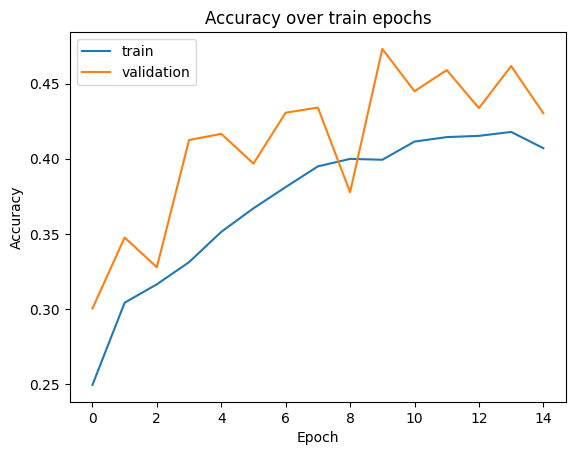

In [12]:
# Entrena el modelo y lo plotea
mlp_model_builder.fit_model()

### Conclusiones

Este primer modelo MLP que probamos no está alcanzando una buena precisión, tanto en el conjunto de entrenamiento como en el de validación. La precisión se mantiene baja (~0.26) y la pérdida es relativamente alta. 

El número de neuronas (1024, 512, 256) podría ser demasiado grande para el problema. Vamos a reducirlas para evitar el sobreajuste, dado que el modelo parece estar teniendo dificultades para generalizar.



Epoch 1/15
264/264 ━━━━━━━━━━━━━━━━━━━━ 85s 320ms/step - accuracy: 0.4148 - loss: 1.4808 - val_accuracy: 0.4765 - val_loss: 1.4072
Epoch 2/15
264/264 ━━━━━━━━━━━━━━━━━━━━ 84s 316ms/step - accuracy: 0.4384 - loss: 1.4505 - val_accuracy: 0.3955 - val_loss: 1.4692
Epoch 3/15
264/264 ━━━━━━━━━━━━━━━━━━━━ 84s 315ms/step - accuracy: 0.4101 - loss: 1.4963 - val_accuracy: 0.4702 - val_loss: 1.3950
Epoch 4/15
264/264 ━━━━━━━━━━━━━━━━━━━━ 83s 314ms/step - accuracy: 0.4255 - loss: 1.4705 - val_accuracy: 0.4519 - val_loss: 1.4251
Epoch 5/15
264/264 ━━━━━━━━━━━━━━━━━━━━ 84s 318ms/step - accuracy: 0.4251 - loss: 1.4570 - val_accuracy: 0.4763 - val_loss: 1.4007
Epoch 6/15
264/264 ━━━━━━━━━━━━━━━━━━━━ 85s 320ms/step - accuracy: 0.4384 - loss: 1.4551 - val_accuracy: 0.4731 - val_loss: 1.4136
Epoch 7/15
264/264 ━━━━━━━━━━━━━━━━━━━━ 86s 325ms/step - accuracy: 0.4254 - loss: 1.4649 - val_accuracy: 0.4168 - val_loss: 1.4590
Epoch 8/15
264/264 ━━━━━━━━━━━━━━━━━━━━ 85s 321ms/step - accuracy: 0.4036 - loss: 1

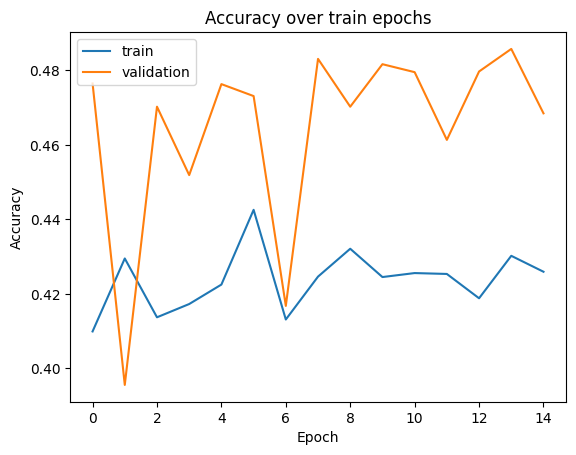

In [13]:
# Entrena el modelo y lo plotea
mlp_model_builder.fit_model()

## Modelo MLP 256 - 128

In [14]:
# Configuración de capas del MLP
layers_config = [
    {'units': 256, 'activation': 'relu', 'dropout': 0.25},
    {'units': 128, 'activation': 'relu', 'dropout': 0.25},
]

mlp_model_builder = MLPBuilder()
mlp_model_builder.build_model(layers_config)
mlp_model_builder.compile_model()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_1 (Flatten)             │ (None, 30000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │     7,680,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,713,926 (29.43 MB)

 Trainable params: 7,713,926 (29.43 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
264/264 ━━━━━━━━━━━━━━━━━━━━ 47s 174ms/step - accuracy: 0.2060 - loss: 4.6179 - val_accuracy: 0.2194 - val_loss: 1.7151
Epoch 2/15
264/264 ━━━━━━━━━━━━━━━━━━━━ 44s 164ms/step - accuracy: 0.2253 - loss: 1.7200 - val_accuracy: 0.2267 - val_loss: 1.7370
Epoch 3/15
264/264 ━━━━━━━━━━━━━━━━━━━━ 45s 168ms/step - accuracy: 0.2523 - loss: 1.6969 - val_accuracy: 0.2449 - val_loss: 1.6958
Epoch 4/15
264/264 ━━━━━━━━━━━━━━━━━━━━ 43s 161ms/step - accuracy: 0.2580 - loss: 1.6900 - val_accuracy: 0.2727 - val_loss: 1.6572
Epoch 5/15
264/264 ━━━━━━━━━━━━━━━━━━━━ 45s 167ms/step - accuracy: 0.2476 - loss: 1.7100 - val_accuracy: 0.2258 - val_loss: 1.7336
Epoch 6/15
264/264 ━━━━━━━━━━━━━━━━━━━━ 44s 164ms/step - accuracy: 0.2562 - loss: 1.6897 - val_accuracy: 0.2991 - val_loss: 1.6164
Epoch 7/15
264/264 ━━━━━━━━━━━━━━━━━━━━ 43s 163ms/step - accuracy: 0.2633 - loss: 1.6859 - val_accuracy: 0.3143 - val_loss: 1.6064
Epoch 8/15
264/264 ━━━━━━━━━━━━━━━━━━━━ 45s 169ms/step - accuracy: 0.2684 - loss: 1

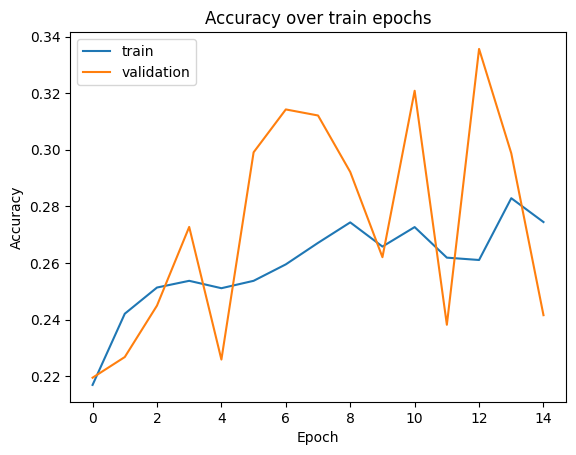

In [15]:
# Entrena el modelo y lo plotea
mlp_model_builder.fit_model()

### Variante del modelo MLP 256 - 128 con menos porcentaje de dropout

In [16]:
# Configuración de capas del MLP
layers_config = [
    {'units': 256, 'activation': 'relu', 'dropout': 0.10},
    {'units': 128, 'activation': 'relu', 'dropout': 0.10},
]

mlp_model_builder = MLPBuilder()
mlp_model_builder.build_model(layers_config)
mlp_model_builder.compile_model()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_2 (Flatten)             │ (None, 30000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 256)            │     7,680,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,713,926 (29.43 MB)

 Trainable params: 7,713,926 (29.43 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
264/264 ━━━━━━━━━━━━━━━━━━━━ 44s 162ms/step - accuracy: 0.2653 - loss: 3.7109 - val_accuracy: 0.2879 - val_loss: 1.6907
Epoch 2/15
264/264 ━━━━━━━━━━━━━━━━━━━━ 43s 161ms/step - accuracy: 0.2943 - loss: 1.6647 - val_accuracy: 0.3053 - val_loss: 1.6259
Epoch 3/15
264/264 ━━━━━━━━━━━━━━━━━━━━ 43s 161ms/step - accuracy: 0.2660 - loss: 1.6680 - val_accuracy: 0.3021 - val_loss: 1.6135
Epoch 4/15
264/264 ━━━━━━━━━━━━━━━━━━━━ 43s 161ms/step - accuracy: 0.2817 - loss: 1.6536 - val_accuracy: 0.3134 - val_loss: 1.5913
Epoch 5/15
264/264 ━━━━━━━━━━━━━━━━━━━━ 43s 161ms/step - accuracy: 0.2759 - loss: 1.6647 - val_accuracy: 0.2690 - val_loss: 1.6444
Epoch 6/15
264/264 ━━━━━━━━━━━━━━━━━━━━ 43s 161ms/step - accuracy: 0.2850 - loss: 1.6379 - val_accuracy: 0.2708 - val_loss: 1.6407
Epoch 7/15
264/264 ━━━━━━━━━━━━━━━━━━━━ 43s 160ms/step - accuracy: 0.2870 - loss: 1.6291 - val_accuracy: 0.2895 - val_loss: 1.6193
Epoch 8/15
264/264 ━━━━━━━━━━━━━━━━━━━━ 43s 161ms/step - accuracy: 0.2935 - loss: 1

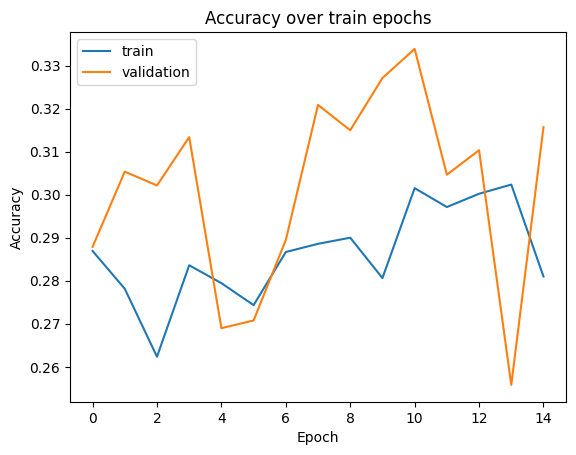

In [17]:
# Entrena el modelo y lo plotea
mlp_model_builder.fit_model()

## Modelo MLP 128 - 64

In [18]:
# Nueva Configuración de Capas del MLP
layers_config = [
    {'units': 128, 'activation': 'tanh', 'dropout': 0.15},
    {'units': 64, 'activation': 'tanh', 'dropout': 0.15},
]

mlp_model_builder = MLPBuilder()
mlp_model_builder.build_model(layers_config)
mlp_model_builder.compile_model()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_3 (Flatten)             │ (None, 30000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │     3,840,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,848,774 (14.68 MB)

 Trainable params: 3,848,774 (14.68 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
264/264 ━━━━━━━━━━━━━━━━━━━━ 40s 145ms/step - accuracy: 0.1835 - loss: 1.9661 - val_accuracy: 0.3102 - val_loss: 1.6962
Epoch 2/15
264/264 ━━━━━━━━━━━━━━━━━━━━ 39s 146ms/step - accuracy: 0.2456 - loss: 1.7890 - val_accuracy: 0.3150 - val_loss: 1.6844
Epoch 3/15
264/264 ━━━━━━━━━━━━━━━━━━━━ 39s 145ms/step - accuracy: 0.2515 - loss: 1.7598 - val_accuracy: 0.3387 - val_loss: 1.6088
Epoch 4/15
264/264 ━━━━━━━━━━━━━━━━━━━━ 39s 145ms/step - accuracy: 0.2485 - loss: 1.7524 - val_accuracy: 0.2749 - val_loss: 1.6837
Epoch 5/15
264/264 ━━━━━━━━━━━━━━━━━━━━ 39s 146ms/step - accuracy: 0.2686 - loss: 1.7043 - val_accuracy: 0.3455 - val_loss: 1.6218
Epoch 6/15
264/264 ━━━━━━━━━━━━━━━━━━━━ 39s 145ms/step - accuracy: 0.2762 - loss: 1.6960 - val_accuracy: 0.3560 - val_loss: 1.5942
Epoch 7/15
264/264 ━━━━━━━━━━━━━━━━━━━━ 39s 145ms/step - accuracy: 0.2386 - loss: 1.7473 - val_accuracy: 0.2635 - val_loss: 1.7348
Epoch 8/15
264/264 ━━━━━━━━━━━━━━━━━━━━ 39s 146ms/step - accuracy: 0.2381 - loss: 1

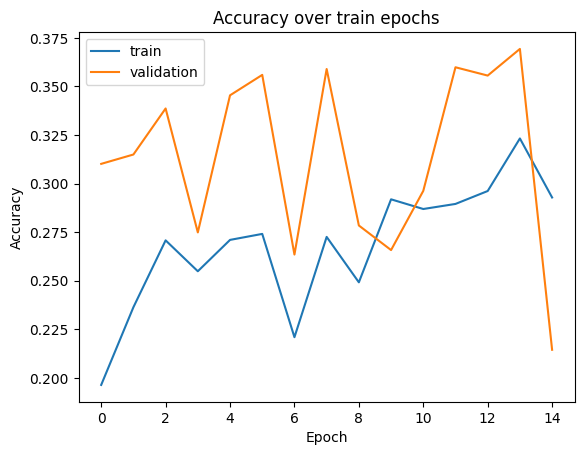

In [19]:
# Entrena el modelo y lo plotea
mlp_model_builder.fit_model()

### Conclusiones

El nuevo modelo simplificado muestra una mejora en la precisión, aunque sigue habiendo espacio para optimizarlo. Actualmente, la precisión en el conjunto de validación se estabiliza entre un 30% y 35%, lo que indica que el modelo aún no está capturando de manera efectiva todas las características del conjunto de datos. Se puede observar que en la época 8 el modelo alcanza su límite de rendimiento, comenzando a presentar signos de sobreajuste.

## Modelo MLP con LeakyReLU y Batch Normalization

In [20]:
layers_config = [
    {'units': 256, 'activation': 'leakyrelu', 'dropout': 0.15},
    {'units': 128, 'activation': 'leakyrelu', 'dropout': 0.15},
]

mlp_model_builder = MLPBuilder()
mlp_model_builder.build_model(layers_config, batch_normalization=True)
mlp_model_builder.compile_model()

/Users/vyj/myenv/lib/python3.12/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_4 (Flatten)             │ (None, 30000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 256)            │     7,680,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,715,462 (29.43 MB)

 Trainable params: 7,714,694 (29.43 MB)

 Non-trainable params: 768 (3.00 KB)

Epoch 1/15
264/264 ━━━━━━━━━━━━━━━━━━━━ 45s 162ms/step - accuracy: 0.3481 - loss: 1.7798 - val_accuracy: 0.4055 - val_loss: 1.5152
Epoch 2/15
264/264 ━━━━━━━━━━━━━━━━━━━━ 43s 161ms/step - accuracy: 0.4260 - loss: 1.4819 - val_accuracy: 0.4116 - val_loss: 1.5496
Epoch 3/15
264/264 ━━━━━━━━━━━━━━━━━━━━ 43s 161ms/step - accuracy: 0.4555 - loss: 1.4122 - val_accuracy: 0.4257 - val_loss: 1.4849
Epoch 4/15
264/264 ━━━━━━━━━━━━━━━━━━━━ 43s 161ms/step - accuracy: 0.4726 - loss: 1.3821 - val_accuracy: 0.3643 - val_loss: 1.7621
Epoch 5/15
264/264 ━━━━━━━━━━━━━━━━━━━━ 44s 164ms/step - accuracy: 0.4692 - loss: 1.3640 - val_accuracy: 0.4426 - val_loss: 1.4790
Epoch 6/15
264/264 ━━━━━━━━━━━━━━━━━━━━ 43s 163ms/step - accuracy: 0.4850 - loss: 1.3343 - val_accuracy: 0.4738 - val_loss: 1.3369
Epoch 7/15
264/264 ━━━━━━━━━━━━━━━━━━━━ 43s 162ms/step - accuracy: 0.4914 - loss: 1.3244 - val_accuracy: 0.4608 - val_loss: 1.4108
Epoch 8/15
264/264 ━━━━━━━━━━━━━━━━━━━━ 43s 163ms/step - accuracy: 0.5005 - loss: 1

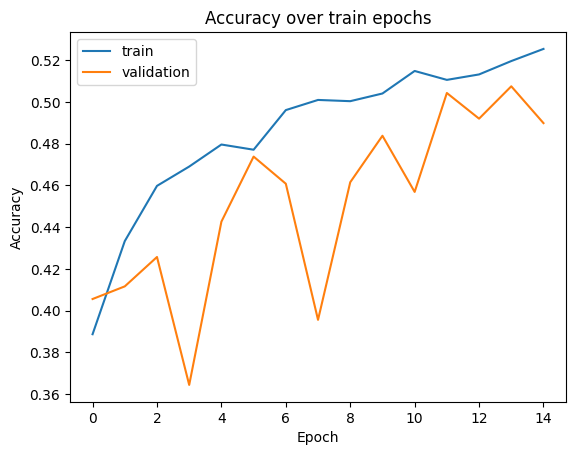

In [21]:
# Entrena el modelo y lo plotea
mlp_model_builder.fit_model()

# Convolucional

# Modelos pre-entrenados

In [22]:
from keras.applications import VGG16, ResNet50, InceptionV3, DenseNet121, MobileNetV2, EfficientNetB0

class CustomPretrainedModel:
    def __init__(self, model_name, custom_layers, num_classes=len(LANDSCAPE_TYPE), input_size=(SIZE, SIZE, 3)):
        """
        Inicializa el modelo pre-entrenado elegido con capas personalizadas.

        Args:
            model_name (str): Nombre del modelo a utilizar ('vgg16', 'resnet50', 'inceptionv3', 
                              'densenet121', 'mobilenetv2', 'efficientnetb0').
            custom_layer (int): Número de neuronas en la capa densa personalizada.
            num_classes (int): Número de clases para la clasificación.
            input_size (tuple): Tamaño de la entrada (altura, ancho, canales).
        """
        self.model_name = model_name
        self.num_classes = num_classes
        self.input_size = input_size
        self.model = self.build_model(custom_layers)

    def build_model(self, custom_layers):
        """
        Construye el modelo pre-entrenado seleccionado con capas personalizadas.

        Returns:
            keras.Model: Modelo con capas personalizadas.
        """
  
        base_model_dict = {
            'vgg16': VGG16,
            'resnet50': ResNet50,
            'inceptionv3': InceptionV3,
            'densenet121': DenseNet121,
            'mobilenetv2': MobileNetV2,
            'efficientnetb0': EfficientNetB0
        }

        # Seleccionar el modelo base según el nombre proporcionado
        model_class = base_model_dict.get(self.model_name.lower())
        
        base_model = model_class(weights='imagenet', include_top=False, input_shape=self.input_size)

        if model_class is None:
            raise ValueError(f"Modelo {self.model_name} no es válido. Elige entre: {', '.join(base_model_dict.keys())}")


        # Congelar las capas del modelo base
        for layer in base_model.layers:
            layer.trainable = False

        # Añadir las capas personalizadas al final del modelo
        x = base_model.output
        x = Flatten()(x)
        x = Dense(custom_layers, activation='relu')(x)  # Capa densa personalizada
        x = Dense(self.num_classes, activation='softmax')(x)  # Capa de salida para clasificación

        # Crear el modelo final
        model = Model(inputs=base_model.input, outputs=x)
        return model

    def compile_model(self, learning_rate=0.001):
        """
        Compila el modelo con el optimizador y la función de pérdida.

        Args:
            learning_rate (float): Tasa de aprendizaje para el optimizador.
        """
        self.model.compile(optimizer=Adam(learning_rate=learning_rate),
                           loss='categorical_crossentropy',
                           metrics=['accuracy'])
        self.model.summary()

    def get_model(self):
        """
        Devuelve el modelo compilado.

        Returns:
            keras.Model: Modelo compilado.
        """
        return self.model

    def fit_model(self, train=train, epochs=15, validation_data=validation):
        """
        Entrena el modelo utilizando los datos proporcionados.
        Args:
            epochs (int): Número de épocas para entrenar.
        """
        return PlotHistory(self.model.fit(train, epochs=epochs, validation_data=validation_data))

Entrenando modelo: vgg16 con 64 capas personalizadas


Model: "functional_36"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 100, 100, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 100, 100, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 50, 50, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 50, 50, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 50, 50, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 25, 25, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 25, 25, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 25, 25, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 25, 25, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 12, 12, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 12, 12, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 12, 12, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 64)             │       294,976 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,010,054 (57.26 MB)

 Trainable params: 295,366 (1.13 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

Epoch 1/15
264/264 ━━━━━━━━━━━━━━━━━━━━ 334s 1s/step - accuracy: 0.6479 - loss: 0.9196 - val_accuracy: 0.7832 - val_loss: 0.5985
Epoch 2/15
264/264 ━━━━━━━━━━━━━━━━━━━━ 363s 1s/step - accuracy: 0.7701 - loss: 0.5917 - val_accuracy: 0.7934 - val_loss: 0.5784
Epoch 3/15
264/264 ━━━━━━━━━━━━━━━━━━━━ 367s 1s/step - accuracy: 0.7986 - loss: 0.5565 - val_accuracy: 0.7925 - val_loss: 0.5530
Epoch 4/15
264/264 ━━━━━━━━━━━━━━━━━━━━ 367s 1s/step - accuracy: 0.8013 - loss: 0.5366 - val_accuracy: 0.7722 - val_loss: 0.6163
Epoch 5/15
264/264 ━━━━━━━━━━━━━━━━━━━━ 410s 2s/step - accuracy: 0.8061 - loss: 0.5104 - val_accuracy: 0.7941 - val_loss: 0.5495
Epoch 6/15
264/264 ━━━━━━━━━━━━━━━━━━━━ 416s 2s/step - accuracy: 0.8175 - loss: 0.4849 - val_accuracy: 0.8034 - val_loss: 0.5206
Epoch 7/15
264/264 ━━━━━━━━━━━━━━━━━━━━ 416s 2s/step - accuracy: 0.8218 - loss: 0.4742 - val_accuracy: 0.8094 - val_loss: 0.5321
Epoch 8/15
264/264 ━━━━━━━━━━━━━━━━━━━━ 414s 2s/step - accuracy: 0.8125 - loss: 0.4980 - val_accu

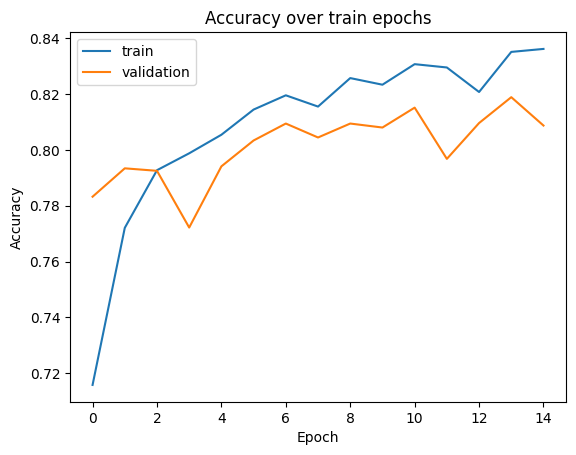

Entrenando modelo: resnet50 con 64 capas personalizadas


Model: "functional_37"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 106, 106,  │          0 │ input_layer_6[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 50, 50,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 50, 50,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 50, 50,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 52, 52,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 25, 25,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 25, 25,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 25, 25,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 25, 25,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 25, 25,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 25, 25,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 25, 25,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 25, 25,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 25, 25,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 25, 25,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 25, 25,    │      1,024 │ conv2_block1_3_c

 Total params: 25,685,318 (97.98 MB)

 Trainable params: 2,097,606 (8.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

Epoch 1/15
264/264 ━━━━━━━━━━━━━━━━━━━━ 202s 743ms/step - accuracy: 0.1725 - loss: 2.1711 - val_accuracy: 0.1790 - val_loss: 1.7913
Epoch 2/15
264/264 ━━━━━━━━━━━━━━━━━━━━ 194s 732ms/step - accuracy: 0.1802 - loss: 1.7977 - val_accuracy: 0.1790 - val_loss: 1.7909
Epoch 3/15
264/264 ━━━━━━━━━━━━━━━━━━━━ 193s 726ms/step - accuracy: 0.1813 - loss: 1.7902 - val_accuracy: 0.1790 - val_loss: 1.7908
Epoch 4/15
264/264 ━━━━━━━━━━━━━━━━━━━━ 194s 731ms/step - accuracy: 0.1864 - loss: 1.7904 - val_accuracy: 0.1790 - val_loss: 1.7908
Epoch 5/15
264/264 ━━━━━━━━━━━━━━━━━━━━ 194s 733ms/step - accuracy: 0.1789 - loss: 1.7967 - val_accuracy: 0.1790 - val_loss: 1.7908
Epoch 6/15
264/264 ━━━━━━━━━━━━━━━━━━━━ 196s 740ms/step - accuracy: 0.1815 - loss: 1.7902 - val_accuracy: 0.1790 - val_loss: 1.7908
Epoch 7/15
264/264 ━━━━━━━━━━━━━━━━━━━━ 196s 738ms/step - accuracy: 0.1747 - loss: 1.7902 - val_accuracy: 0.1790 - val_loss: 1.7908
Epoch 8/15
264/264 ━━━━━━━━━━━━━━━━━━━━ 194s 732ms/step - accuracy: 0.1720 -

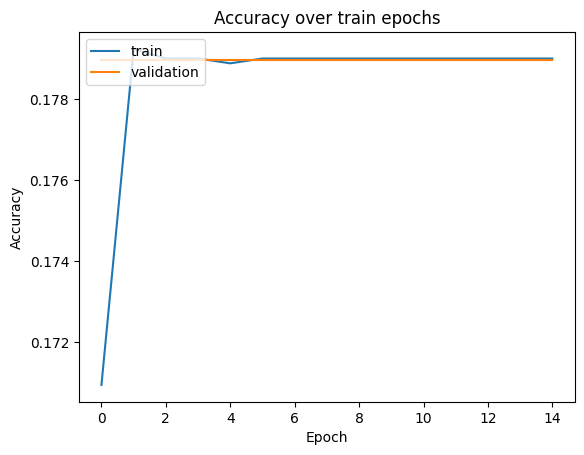

Entrenando modelo: inceptionv3 con 64 capas personalizadas
87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step


Model: "functional_38"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 49, 49,    │        864 │ input_layer_7[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 49, 49,    │         96 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 49, 49,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 47, 47,    │      9,216 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 47, 47,    │         96 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 47, 47,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 47, 47,    │     18,432 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 47, 47,    │        192 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 47, 47,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 23, 23,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 23, 23,    │      5,120 │ max_pooling2d[0]… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 23, 23,    │        240 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 23, 23,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 21, 21,    │    138,240 │ activation_3[0][… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 21, 21,    │        576 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 21, 21,    │          0 │ batch_normalizat

 Total params: 21,934,310 (83.67 MB)

 Trainable params: 131,526 (513.77 KB)

 Non-trainable params: 21,802,784 (83.17 MB)

Epoch 1/15
264/264 ━━━━━━━━━━━━━━━━━━━━ 165s 600ms/step - accuracy: 0.5400 - loss: 1.2118 - val_accuracy: 0.7059 - val_loss: 0.8019
Epoch 2/15
264/264 ━━━━━━━━━━━━━━━━━━━━ 158s 594ms/step - accuracy: 0.7003 - loss: 0.8033 - val_accuracy: 0.7062 - val_loss: 0.7855
Epoch 3/15
264/264 ━━━━━━━━━━━━━━━━━━━━ 157s 591ms/step - accuracy: 0.7044 - loss: 0.7746 - val_accuracy: 0.7234 - val_loss: 0.7343
Epoch 4/15
264/264 ━━━━━━━━━━━━━━━━━━━━ 260s 980ms/step - accuracy: 0.7229 - loss: 0.7517 - val_accuracy: 0.7381 - val_loss: 0.7072
Epoch 5/15
264/264 ━━━━━━━━━━━━━━━━━━━━ 355s 1s/step - accuracy: 0.7341 - loss: 0.7130 - val_accuracy: 0.7390 - val_loss: 0.6876
Epoch 6/15
264/264 ━━━━━━━━━━━━━━━━━━━━ 285s 1s/step - accuracy: 0.7427 - loss: 0.7051 - val_accuracy: 0.7453 - val_loss: 0.6900
Epoch 7/15
264/264 ━━━━━━━━━━━━━━━━━━━━ 278s 992ms/step - accuracy: 0.7400 - loss: 0.6967 - val_accuracy: 0.7333 - val_loss: 0.6868
Epoch 8/15
264/264 ━━━━━━━━━━━━━━━━━━━━ 307s 1s/step - accuracy: 0.7471 - loss: 0.

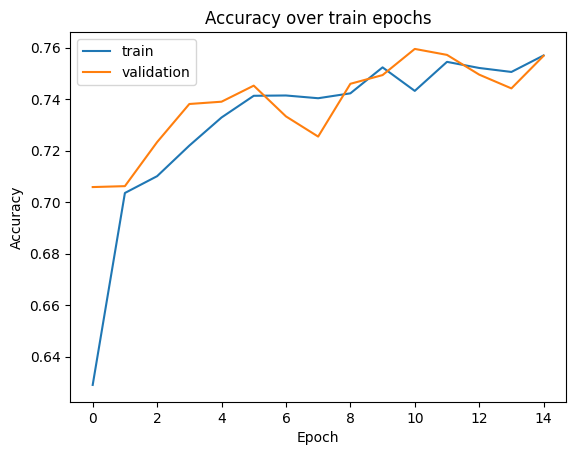

Entrenando modelo: densenet121 con 64 capas personalizadas
29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "functional_39"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8       │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 106, 106,  │          0 │ input_layer_8[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 50, 50,    │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 50, 50,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 50, 50,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 52, 52,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 25, 25,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 25, 25,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 25, 25,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 25, 25,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 25, 25,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 25, 25,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 25, 25,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 25, 25,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 25, 25,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 25, 25,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 25, 25,    │     12,288 │ conv2_block2_0_r

 Total params: 7,627,782 (29.10 MB)

 Trainable params: 590,278 (2.25 MB)

 Non-trainable params: 7,037,504 (26.85 MB)

Epoch 1/15
264/264 ━━━━━━━━━━━━━━━━━━━━ 201s 714ms/step - accuracy: 0.6888 - loss: 0.9937 - val_accuracy: 0.8082 - val_loss: 0.5279
Epoch 2/15
264/264 ━━━━━━━━━━━━━━━━━━━━ 191s 724ms/step - accuracy: 0.8322 - loss: 0.4794 - val_accuracy: 0.8228 - val_loss: 0.4979
Epoch 3/15
264/264 ━━━━━━━━━━━━━━━━━━━━ 179s 675ms/step - accuracy: 0.8401 - loss: 0.4456 - val_accuracy: 0.8449 - val_loss: 0.4230
Epoch 4/15
264/264 ━━━━━━━━━━━━━━━━━━━━ 178s 674ms/step - accuracy: 0.8453 - loss: 0.4185 - val_accuracy: 0.8442 - val_loss: 0.4406
Epoch 5/15
264/264 ━━━━━━━━━━━━━━━━━━━━ 189s 715ms/step - accuracy: 0.8470 - loss: 0.4106 - val_accuracy: 0.8487 - val_loss: 0.4343
Epoch 6/15
264/264 ━━━━━━━━━━━━━━━━━━━━ 175s 660ms/step - accuracy: 0.8541 - loss: 0.3829 - val_accuracy: 0.8460 - val_loss: 0.4177
Epoch 7/15
264/264 ━━━━━━━━━━━━━━━━━━━━ 166s 628ms/step - accuracy: 0.8471 - loss: 0.4043 - val_accuracy: 0.8446 - val_loss: 0.4264
Epoch 8/15
264/264 ━━━━━━━━━━━━━━━━━━━━ 170s 641ms/step - accuracy: 0.8550 -

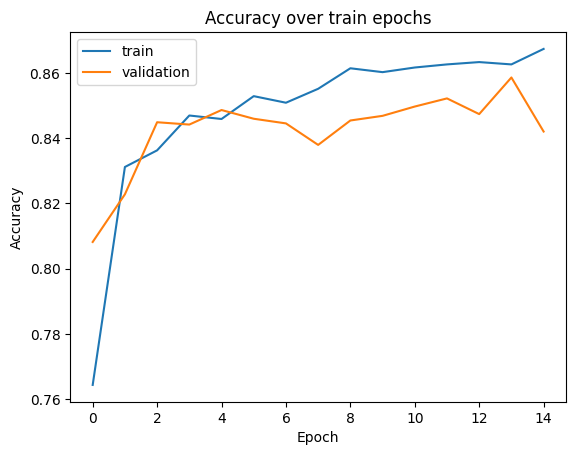

Entrenando modelo: mobilenetv2 con 64 capas personalizadas


/var/folders/j2/v0jwr_xj52d6wqq0xkm3dshw0000gn/T/ipykernel_45404/4287117977.py:40: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = model_class(weights='imagenet', include_top=False, input_shape=self.input_size)


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional_40"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9       │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 50, 50,    │        864 │ input_layer_9[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 50, 50,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 50, 50,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 50, 50,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 50, 50,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 50, 50,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 50, 50,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 50, 50,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 50, 50,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 50, 50,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 50, 50,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 51, 51,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 25, 25,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 25, 25,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 25, 25,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 25, 25,    │      2,304 │ block_1_depthwis

 Total params: 3,569,158 (13.62 MB)

 Trainable params: 1,311,174 (5.00 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/15
264/264 ━━━━━━━━━━━━━━━━━━━━ 70s 253ms/step - accuracy: 0.6028 - loss: 1.7033 - val_accuracy: 0.7920 - val_loss: 0.5844
Epoch 2/15
264/264 ━━━━━━━━━━━━━━━━━━━━ 66s 248ms/step - accuracy: 0.7889 - loss: 0.5933 - val_accuracy: 0.8132 - val_loss: 0.5473
Epoch 3/15
264/264 ━━━━━━━━━━━━━━━━━━━━ 66s 248ms/step - accuracy: 0.8155 - loss: 0.5223 - val_accuracy: 0.7996 - val_loss: 0.5583
Epoch 4/15
264/264 ━━━━━━━━━━━━━━━━━━━━ 65s 244ms/step - accuracy: 0.8240 - loss: 0.5041 - val_accuracy: 0.8162 - val_loss: 0.5119
Epoch 5/15
264/264 ━━━━━━━━━━━━━━━━━━━━ 67s 250ms/step - accuracy: 0.8393 - loss: 0.4554 - val_accuracy: 0.8212 - val_loss: 0.4928
Epoch 6/15
264/264 ━━━━━━━━━━━━━━━━━━━━ 66s 249ms/step - accuracy: 0.8485 - loss: 0.4420 - val_accuracy: 0.8365 - val_loss: 0.4604
Epoch 7/15
264/264 ━━━━━━━━━━━━━━━━━━━━ 67s 251ms/step - accuracy: 0.8447 - loss: 0.4278 - val_accuracy: 0.8360 - val_loss: 0.4584
Epoch 8/15
264/264 ━━━━━━━━━━━━━━━━━━━━ 68s 255ms/step - accuracy: 0.8326 - loss: 0

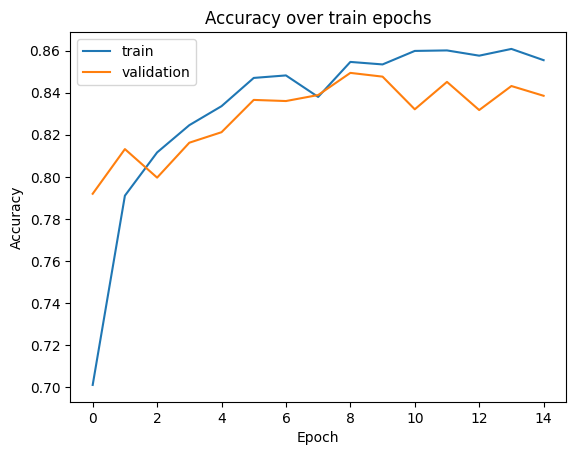

Entrenando modelo: efficientnetb0 con 64 capas personalizadas
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional_41"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10      │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 100, 100,  │          0 │ input_layer_10[0… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 100, 100,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 100, 100,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 101, 101,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 50, 50,    │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 50, 50,    │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 50, 50,    │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 50, 50,    │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 50, 50,    │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 50, 50,    │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 50, 50,    │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 50, 50,    │        512 │ block1a_se_excit

 Total params: 5,360,745 (20.45 MB)

 Trainable params: 1,311,174 (5.00 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

Epoch 1/15
264/264 ━━━━━━━━━━━━━━━━━━━━ 163s 584ms/step - accuracy: 0.1719 - loss: 2.3336 - val_accuracy: 0.1713 - val_loss: 1.7913
Epoch 2/15
264/264 ━━━━━━━━━━━━━━━━━━━━ 157s 589ms/step - accuracy: 0.1799 - loss: 1.7913 - val_accuracy: 0.1790 - val_loss: 1.7909
Epoch 3/15
264/264 ━━━━━━━━━━━━━━━━━━━━ 158s 594ms/step - accuracy: 0.1787 - loss: 1.7908 - val_accuracy: 0.1790 - val_loss: 1.7908
Epoch 4/15
264/264 ━━━━━━━━━━━━━━━━━━━━ 158s 593ms/step - accuracy: 0.1747 - loss: 1.7910 - val_accuracy: 0.1790 - val_loss: 1.7908
Epoch 5/15
264/264 ━━━━━━━━━━━━━━━━━━━━ 157s 591ms/step - accuracy: 0.1789 - loss: 1.7905 - val_accuracy: 0.1790 - val_loss: 1.7908
Epoch 6/15
264/264 ━━━━━━━━━━━━━━━━━━━━ 19127s 73s/step - accuracy: 0.1882 - loss: 1.7902 - val_accuracy: 0.1790 - val_loss: 1.7908
Epoch 7/15
264/264 ━━━━━━━━━━━━━━━━━━━━ 151s 570ms/step - accuracy: 0.1759 - loss: 1.7905 - val_accuracy: 0.1790 - val_loss: 1.7908
Epoch 8/15
264/264 ━━━━━━━━━━━━━━━━━━━━ 153s 574ms/step - accuracy: 0.1823 -

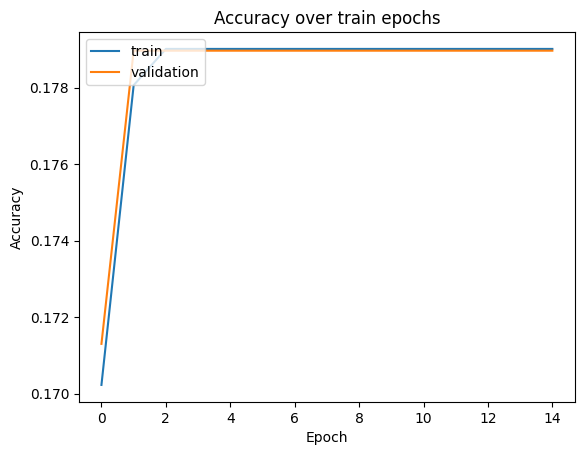

In [23]:
# Lista de modelos a probar junto con el número de capas personalizadas
model_names = [
    ('vgg16', 64),
    ('resnet50', 64),
    ('inceptionv3', 64),
    ('densenet121', 64),
    ('mobilenetv2', 64),
    ('efficientnetb0', 64)
]

# Entrenar cada modelo
for model_name, custom_layers in model_names:
    print(f"Entrenando modelo: {model_name} con {custom_layers} capas personalizadas")
    custom_model = CustomPretrainedModel(model_name=model_name, custom_layers=custom_layers)
    custom_model.compile_model()
    custom_model.fit_model()